# Load and preprocessing

## Notebook settings

In [1]:
%config IPCompleter.greedy=True
%pylab inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_directory = '../data/UCRArchive_2018'
checkpoints_directory = 'checkpoints'

## Dataset selection

In [3]:
dataset_names = ['ECG5000', 'ECG200', 'ChlorineConcentration', 'FordA', 'FordB', 'PhalangesOutlinesCorrect'
                 , 'RefrigerationDevices', 'TwoLeadECG', 'TwoPatterns']
dataset_name = 'PhalangesOutlinesCorrect'

## Load Utility Script

In [4]:
# %load ../scripts/dataUtilities.py
import pandas as pd
import numpy as np
import sklearn.preprocessing as pp


def load_data(direc, dataset, perm=True, ratio_train=0.8):
    datadir = direc + '/' + dataset + '/' + dataset
    data_train = np.genfromtxt(datadir + '_TRAIN.tsv', delimiter='\t')
    data_test_val = np.genfromtxt(datadir + '_TEST.tsv', delimiter='\t')[:-1]
    data = np.concatenate((data_train, data_test_val), axis=0)

    N, D = data.shape
    ind_cut = int(ratio_train * N)
    if perm:
        ind = np.random.permutation(N)
    else:
        ind = range(0, N)
    return data[ind[:ind_cut], 1:], data[ind[ind_cut:], 1:], data[ind[:ind_cut], 0], data[ind[ind_cut:], 0]


def rebuild_data(data_train, data_test, labels_train, labels_test):
    all_data = np.concatenate((data_train, data_test))
    all_labels = np.concatenate((labels_train, labels_test)).reshape(-1, 1)
    return np.concatenate((all_labels, all_data), axis=1)


def remove_outlier(dataset):
    df = pd.DataFrame(dataset)
    for col in df:
        low_threshold = df[col].quantile(0.03)
        high_threshold = df[col].quantile(0.97)
        df.loc[df[col] < low_threshold, col] = low_threshold
        df.loc[df[col] > high_threshold, col] = high_threshold
    return df.to_numpy()


def scale_data(dataset):
    min_max_scaler = pp.MinMaxScaler()
    dataset_scaled = min_max_scaler.fit_transform(dataset)
    return dataset_scaled


def plot_dataframe(dataset, title):
    pd.DataFrame(dataset).plot(legend=False, title=title)


## Split dataset

In [5]:
data_train, data_test, labels_train, labels_test = load_data(data_directory, dataset_name)

## Dataset shapes and classes

In [6]:
train_size = data_train.shape[0]
test_size = data_test.shape[0]
seq_length = data_train.shape[1] # Time series sequence length
print('Train set samples:', train_size)
print('Test set samples:', test_size)
print('Dimensions (columns):', seq_length)

num_classes = len(np.unique(labels_train))
base = int(np.min(labels_train))  # Check if data is 0-based
if base != 0:
    labels_train -= base
    labels_test -= base

print('There are', num_classes, 'classes,', base, 'is the min class value')

Train set samples: 2125
Test set samples: 532
Dimensions (columns): 80
There are 2 classes, 0 is the min class value


## Data Profiling

## Data Preprocessing

In [7]:
# Train data
#plot_data(data_train, 'Before')
data_train = remove_outlier(data_train)
#data_train = scale_data(data_train)
#plot_data(data_train, 'After')

# Test data
#plot_data(data_test, 'Before')
data_test = remove_outlier(data_test)
#data_test = scale_data(data_test)
#plot_data(data_test, 'After')

## Load sample plotting script

In [8]:
# %load ../scripts/plotUtilities.py 
import numpy as np
from collections import Counter


def plot_data(data, classes, plot_row=10, save=False, name='tmp', adjust=True):
    counts = dict(Counter(classes))
    uniqueClasses = np.unique(classes)
    num_classes = len(uniqueClasses)
    f, axarr = plt.subplots(plot_row, num_classes)
    for selectedClass in uniqueClasses:  # Loops over classes, plot as columns
        selectedClass = int(selectedClass)
        ind = np.where(classes == selectedClass)
        ind_plot = np.random.choice(ind[0], size=plot_row)
        for n in range(plot_row):  # Loops over rows
            # Only shops axes for bottom row and left column
            if n == 0:
                axarr[n, selectedClass].set_title(
                    'Class %.0f (%.0f elements)' % (selectedClass + 1, counts[float(selectedClass)]))
            if n < counts[float(selectedClass)]:
                axarr[n, selectedClass].plot(data[ind_plot[n], :])

                if not n == plot_row - 1:
                    plt.setp([axarr[n, selectedClass].get_xticklabels()], visible=False)
                if not selectedClass == 0:
                    plt.setp([axarr[n, selectedClass].get_yticklabels()], visible=False)

    if adjust == True:
        f.subplots_adjust(hspace=0)  # No horizontal space between subplots
        f.subplots_adjust(wspace=0)  # No vertical space between subplots
    plt.show()

    if save:
        plt.savefig(name, format='png', dpi=1000)

    return


## Training sample plotting

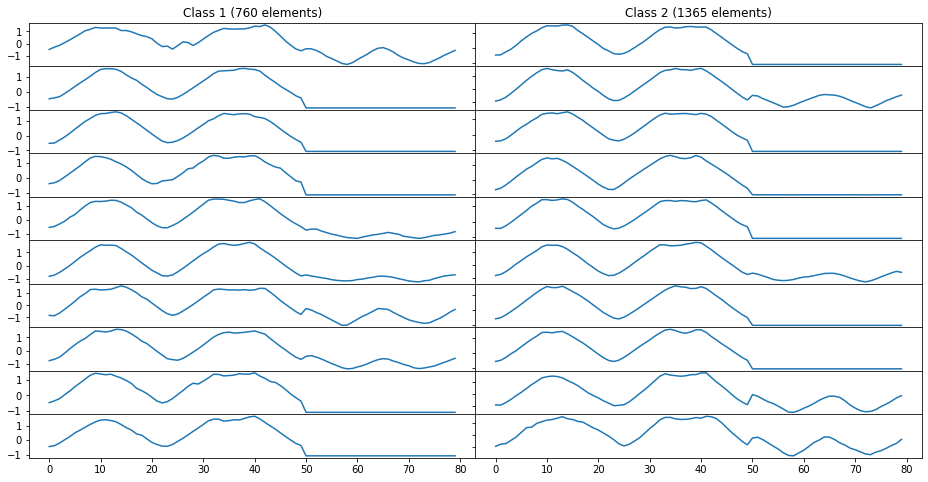

In [9]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(data_train, labels_train)

# Model definition and training

### Net description
**dropout**: A single model can be used to simulate having a large number of different network architectures by randomly dropping out nodes during training. This is called dropout and offers a very computationally cheap and remarkably effective regularization method to reduce overfitting and improve generalization error in deep neural networks of all kinds.


In [10]:
# %load ../scripts/autoencoder.py
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell
import tensorflow_probability as tfp

class Model:
    def __init__(self, config):
        # Hyperparameters of the net
        num_layers = config['num_layers']
        hidden_size = config['hidden_size']
        max_grad_norm = config['max_grad_norm']
        batch_size = config['batch_size']
        seq_length = config['seq_length']
        crd = config['crd']
        num_l = config['num_l']
        learning_rate = config['learning_rate']
        self.seq_length = seq_length
        self.batch_size = batch_size

        # Nodes for the input variables
        self.x = tf.placeholder("float", shape=[batch_size, seq_length], name='Input_data')
        self.x_exp = tf.expand_dims(self.x, 1)
        self.keep_prob = 1 - dropout

        with tf.variable_scope("Encoder", reuse=tf.AUTO_REUSE):
            # The encoder cell, multi-layered with dropout
            # Number of LSTM = hidden layer size
            cell_enc = tf.keras.layers.StackedRNNCells([
                tf.keras.layers.LSTMCell(
                    hidden_size,
                    dropout=self.keep_prob
                ) for _ in range(num_layers)
            ])
            # Initial state, tuple for all lstms stacked
            # layer for mean of z
            W_mu = tf.get_variable('W_mu', [hidden_size, num_l])

            # Creates a recurrent neural network specified by RNNCell cell
            # outputs is a length T list of outputs (one for each input), or a nested tuple of such elements.
            # in our case one output for each time series in input
            stacked_layer = tf.keras.layers.RNN(cell_enc, unroll=True)

            cell_output = stacked_layer(self.x_exp)
            b_mu = tf.get_variable('b_mu', [num_l])

            # self.z_mu is the Tensor containing the hidden representations
            # It can be used to do visualization, clustering or subsequent classification
            # tf.nn.xw_plus_b computes matmul(x, weights) + biases.
            self.z_mu = tf.nn.xw_plus_b(cell_output, W_mu, b_mu, name='z_mu')  # mu, mean, of latent space

            # Calculate the mean and variance of the latent space
            # The mean and variance are calculated by aggregating the contents of z_mu across axes
            lat_mean, lat_var = tf.nn.moments(self.z_mu, axes=[1])

            # Train the point in latent space to have zero-mean and unit-variance on batch basis
            self.loss_lat_batch = tf.reduce_mean(tf.square(lat_mean) + lat_var - tf.log(lat_var) - 1)

        with tf.name_scope("Lat_2_dec"):
            # layer to generate initial state
            W_state = tf.get_variable('W_state', [num_l, hidden_size])
            b_state = tf.get_variable('b_state', [hidden_size])
            z_state = tf.nn.xw_plus_b(self.z_mu, W_state, b_state, name='z_state')  # mu, mean, of latent space

        # Similar steps as encoder
        with tf.variable_scope("Decoder"):
            # The decoder, also multi-layered
            cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_size) for _ in range(num_layers)])

            # Initial state
            initial_state_dec = tuple([(z_state, z_state)] * num_layers)
            dec_inputs = [tf.zeros([batch_size, 1])] * seq_length

            outputs_dec, _ = tf.contrib.rnn.static_rnn(cell_dec,
                                                       inputs=dec_inputs,
                                                       initial_state=initial_state_dec)
        with tf.name_scope("Out_layer"):
            params_o = 2 * crd  # Number of coordinates + variances
            W_o = tf.get_variable('W_o', [hidden_size, params_o])
            b_o = tf.get_variable('b_o', [params_o])
            outputs = tf.concat(outputs_dec, axis=0)  # tensor in [seq_length*batch_size,hidden_size]
            h_out = tf.nn.xw_plus_b(outputs, W_o, b_o)
            h_mu, h_sigma_log = tf.unstack(tf.reshape(h_out, [seq_length, batch_size, params_o]), axis=2)
            h_sigma = tf.exp(h_sigma_log)
            dist = tfp.distributions.Normal(h_mu, h_sigma)
            px = dist.log_prob(tf.transpose(self.x))
            loss_seq = -px
            self.loss_seq = tf.reduce_mean(loss_seq)

        with tf.name_scope("train"):
            global_step = tf.Variable(0, trainable=False)
            # Use learning rate decay
            # Useful use a learning rate schedule to reduce learning rate as the training progresses.
            lr = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.1, staircase=False)

            self.loss = self.loss_seq + self.loss_lat_batch

            # Route the gradients
            tvars = tf.trainable_variables()
            # We clip the gradients to prevent explosion
            grads = tf.gradients(self.loss, tvars)
            grads, _ = tf.clip_by_global_norm(grads, max_grad_norm)
            self.numel = tf.constant([[0]])

            # And apply the gradients
            optimizer = tf.train.AdamOptimizer(lr)
            gradients = zip(grads, tvars)
            self.train_step = optimizer.apply_gradients(gradients, global_step=global_step)

            self.numel = tf.constant([[0]])

        tf.summary.tensor_summary('lat_state', self.z_mu)
        # Define one op to call all summaries
        self.merged = tf.summary.merge_all()
        # Returns an Op that initializes global variables.
        self.init_op = tf.global_variables_initializer()

## Configuration hyperparameter

In [11]:
dataset_configs = {
    # Done
    'ECG5000': {
        'num_layers': 2,  # number of layers of stacked RNN's
        'hidden_size': 32,  # memory cells in a layer
        'max_grad_norm': 5,  # maximum gradient norm during training
        'batch_size': 48, # number of samples for iteration
        'learning_rate': .003, # for exponential decay
        'crd': 1,  # Hyperparameter for future generalization
        'num_l': 32, # number of units in the latent space
        'max_iterations': 1500
    },
    # Done
    'ECG200': {
        'num_layers': 2,
        'hidden_size': 16,
        'max_grad_norm': 5,
        'batch_size': 8,
        'learning_rate': .003,
        'crd': 1,
        'num_l': 16,
        'max_iterations': 2000
    },
    # Done
    'ChlorineConcentration': {
        'num_layers': 2,
        'hidden_size': 48,
        'max_grad_norm': 5,
        'batch_size': 32,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32,
        'max_iterations': 1500
    },
    'FordA': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32,
        'max_iterations': 1000
    },
    'FordB': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32,
        'max_iterations': 1000
    },
    # Doing
    'PhalangesOutlinesCorrect': {
        'num_layers': 2,
        'hidden_size': 8,
        'max_grad_norm': 5,
        'batch_size': 16,
        'learning_rate': .003,
        'crd': 1,
        'num_l': 8,
        'max_iterations': 1500
    },
    'RefrigerationDevices': {
        'num_layers': 2,
        'hidden_size': 90,
        'max_grad_norm': 5,
        'batch_size': 64,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32,
        'max_iterations': 1000
    },
    # Done
    'TwoLeadECG': {
        'num_layers': 2,
        'hidden_size': 16,
        'max_grad_norm': 5,
        'batch_size': 16,
        'learning_rate': .001,
        'crd': 1,
        'num_l': 16,
        'max_iterations': 1000
    },
    # Done
    'TwoPatterns': {
        'num_layers': 2,
        'hidden_size': 42,
        'max_grad_norm': 5,
        'batch_size': 32,
        'learning_rate': .005,
        'crd': 1,
        'num_l': 32,
        'max_iterations': 2000
    }
}
plot_every = 50  # after _plot_every_ GD steps, there's console output
dropout = 0.8 # Dropout rate
config = dataset_configs[dataset_name]
config['seq_length'] = seq_length;  # Time series sequence length
print(config)

{'num_layers': 2, 'hidden_size': 8, 'max_grad_norm': 5, 'batch_size': 16, 'learning_rate': 0.003, 'crd': 1, 'num_l': 8, 'max_iterations': 1500, 'seq_length': 80}


## Training time

In [12]:
import tensorflow as tf
import datetime, os

os.makedirs(checkpoints_directory, exist_ok=True)

In [ ]:
model = Model(config)
sess = tf.Session()

max_iterations = config['max_iterations']  # maximum number of iterations
perf_collect = np.zeros((2, int(np.ceil(max_iterations / plot_every)+1)))
batch_size = config['batch_size']

# Number of samples according to batch_size
actual_test_size = (test_size // batch_size) * batch_size
actual_data_test = data_test[0:actual_test_size]
actual_labels_test = labels_test[0:actual_test_size]

# Start of the train
epochs = np.floor(batch_size * max_iterations / train_size)

print('Train with approximately %d epochs' % epochs)

sess.run(model.init_op)

step = 0  # Step is a counter for filling the numpy array perf_collect
for i in range(max_iterations):
    batch_ind = np.random.choice(train_size, batch_size, replace=False)
    #current = (i * batch_size) % actual_train_size
    #batch_ind = np.arange(current, current + batch_size)
    result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.train_step],
                      feed_dict={model.x: data_train[batch_ind]})
    
    if (i == 0) or (((i+1) % plot_every) == 0):
        # Save train performances
        perf_collect[0, step] = loss_train = result[0]
        loss_train_seq, lost_train_lat = result[1], result[2]

        # Calculate and save validation performance
        batch_ind_val = np.random.choice(test_size, batch_size, replace=False)

        result = sess.run([model.loss, model.loss_seq, model.loss_lat_batch, model.merged],
                          feed_dict={model.x: data_test[batch_ind_val]})
        perf_collect[1, step] = loss_val = result[0]
        loss_val_seq, lost_val_lat = result[1], result[2]
        # and save to Tensorboard
        summary_str = result[3]

        print("At %6s / %6s train (%5.3f, %5.3f, %5.3f), val (%5.3f, %5.3f,%5.3f) in order (total, seq, lat)" % (
        i+1, max_iterations, loss_train, loss_train_seq, lost_train_lat, loss_val, loss_val_seq, lost_val_lat))
        step += 1
    
saver = tf.train.Saver()
saver.save(sess, os.path.join(checkpoints_directory, dataset_name))

print("model trained, saved in logs directory")

W0728 12:22:28.013785  4104 deprecation.py:506] From d:\workspaces\ideaprojects\progetto-data-science\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0728 12:22:29.161776  4104 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0728 12:22:29.163830  4104 deprecation.py:323] From <ipython-input-10-1f6307ac7860>:67: MultiRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated 

## Extract latent vector of test samples

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, save_path=os.path.join(checkpoints_directory, dataset_name))

# Extract the latent space coordinates of the validation set

start = 0
label = []  # The label to save to visualize the latent space
z_run_clust = [] # Latent space for clustering
z_run_emb = [] # Latent space for tSNE

while start + batch_size <= actual_test_size:
    run_ind = range(start, start + batch_size)
    z_mu_fetch = sess.run(model.z_mu, feed_dict={model.x: actual_data_test[run_ind]})
    z_run_clust.extend(z_mu_fetch.tolist())
    z_run_emb.append(z_mu_fetch)

    start += batch_size

## Visualize latent vector on PCA and tSNE

## Ploting test samples

In [ ]:
pylab.rcParams['figure.figsize'] = (16, 8)
plot_data(actual_data_test, actual_labels_test)

# Clustering on test latent vectors

## Load Metrics script

In [ ]:
# %load ../scripts/metrics.py
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score \
    , adjusted_mutual_info_score, v_measure_score, fowlkes_mallows_score
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
#from .dunn import dunn


# Misura la densità del clustering, ovvero quanto un sample è simile agli altri punto dello stesso cluster
# e quanto bene dista dal cluster più vicino usando una metrica di similarità (euclidea, cosine, ecc).
# Questo score è la media di tutti i silhouette score di ciascun sample
# DTW is fine for TS but it takes too long
def silhouette(dataset, clustering):
    return silhouette_score(dataset, clustering, metric='euclidean')


# DB: Misura la separazione tra cluster, compiendo una media artimetica delle similarità tra coppie di cluster più simili
# , usandodi una misura di similarità tra cluster ad hoc che mette a rapporto la somma dei diametri
# dei cluster (media distanza euclidea intra-cluster) e la distanza euclidea tra i rispettivi centroidi.
# Più tende a 0 meglio è. Fvorisce cluster densi e ben distanti
# Più veloce di silhouette ma limitato alla distanza euclidea
def db(dataset, clustering):
    return davies_bouldin_score(dataset, clustering)


# Dunn Index is heavy and good for small datasets. TODO
#def di(dataset, clustering):
#    distances = euclidean_distances(dataset)
#    return dunn(clustering, distances)


# Righe le label e colonne i cluster
def cm(y_true, y_pred):
    return contingency_matrix(y_true, y_pred)


# Media tra tutti i cluster del numero di sample della label più presente di ciascun cluster.
# Da' una misura di quanto bene il clustering copre il labelling. Se è 1, il clustering ha coperto tutte le label
# , anche ricorrendo ad un numero di cluster maggiore delle classi
def purity(y_true, y_pred):
    cont_matrix = cm(y_true, y_pred)
    return np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)


def rel_purity(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    labels_sum = np.sum(cm, axis=1)
    rm = np.zeros(cm.shape)
    for j in range(cm.shape[1]):
        for i in range(cm.shape[0]):
            rm[i][j] = cm[i][j] / labels_sum[i]
    # print("Relative Contingency Matrix")
    # print(rm)
    # print(np.max(rm, axis=0))

    max_indexes = np.argmax(rm, axis=0)
    # print(max_indexes)
    sum = 0
    for j in range(rm.shape[1]):
        sum += cm[max_indexes[j]][j]
    return sum / np.sum(cm)


# ARI: fix dell'RI, che mette a rapporto il numero di true (se due sample sono nello stesso cluster allora hanno la stessa label
# + se due sample sono in cluster diversi allora hanno diversa label) sul numero totaale di coppie non ordinate di sample
# va bene quando si vuole un clustering molto fedele al labelling del dataset. Valida per dataset i cui sample appartengono a classi ben distanti.
# Immune al random labelling: https://scikit-learn.org/stable/auto_examples/cluster/plot_adjusted_for_chance_measures.html#sphx-glr-auto-examples-cluster-plot-adjusted-for-chance-measures-py
# Rule of thumb: Use ARI when the ground truth clustering has large equal sized clusters
def ari(y_true, y_pred):
    return adjusted_rand_score(y_true, y_pred)


# FMS: Media geometrica di precision e recall pairwise
def fmi(y_true, y_pred):
    return fowlkes_mallows_score(y_true, y_pred)


# AMIS: fix del MIS, basata sull'entropia di Von Neuman, calcolata per le label e per i cluster
# Immune al random labelling
# Rule of thumb: Usa AMI when the ground truth clustering is unbalanced and there exist small clusters
def ami(y_true, y_pred):
    return adjusted_mutual_info_score(y_true, y_pred, average_method='arithmetic')


# Media armonica di Homogeneity e Completeness.
# Homogeneity: Quanto un cluster ha sample di una sola label
# Completeness: Quanto i sample di una label stanno in un solo cluster
# Entrambi basati sull'entropia di Von Neumann
# Debole al random clustering con alto numero di cluster. Non buono con dataset piccoli e/o grande numero di cluster
def vm(y_true, y_pred):
    return v_measure_score(y_true, y_pred)


## Load Clustering Script

In [ ]:
# %load ../scripts/clustering.py
from sklearn.cluster import KMeans


def getClustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=100)
    clustering = kmeans.fit_predict(features)
    kmeans.labels_ += 1
    clustering = clustering -1
    return clustering

## Clustering, plotting and metrics

In [ ]:
ground_labels =[ int(lt) + 1 for lt in actual_labels_test ]
if num_classes <= 3:
    num_clusters = [2, 3, 4, 5, 6]
else:
    num_clusters = [num_classes - 2, num_classes - 1, num_classes, num_classes + 1, num_classes + 2]

metric_df = pd.DataFrame()
for nc in num_clusters:
    print('Clustering: ', nc, '- Means')
    clustering = getClustering(z_run_clust, nc)
    pylab.rcParams['figure.figsize'] = (16, 8)
    #plot_data(actual_data_test, clustering)
    
    metric_row = {'Silhouette': round(silhouette(actual_data_test, clustering), 3),
                  'DB': round(db(actual_data_test, clustering), 3),
                  #'Dunn': round(di(ground_labels, clustering), 3),
                  'Purity': round(purity(ground_labels, clustering), 3),
                  'Rel. Purity': round(rel_purity(ground_labels, clustering), 3),
                  'ARI': round(ari(ground_labels, clustering), 3),
                  'FMI': round(fmi(ground_labels, clustering), 3),
                  #'AMI': round(ami(ground_labels, clustering), 3),
                  #'VM': round(vm(ground_labels, clustering), 3)
                 }
    metric_row_df = pd.DataFrame(metric_row, index=[str(nc)])
    metric_df = metric_df.append(metric_row_df)
    print('Contingecy matrix\n', cm(ground_labels, clustering))
    print('\n\n')
    
metric_df.index.name = 'Clusters'
csv_filename = '../export/' + dataset_name + '_metrics.csv'
metric_df.to_csv(path_or_buf=csv_filename, mode='w+')
metric_df